In [1]:
# from transformers import TrOCRProcessor, VisionEncoderDecoderModel

In [1]:
import glob, os, yaml, pprint, string
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def imshow(im, ocv_format=True):
    binary = im.shape[0] == 1
    if ocv_format and not binary:
        im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    plt.imshow(im, cmap='gray' if binary else None)

def imdisplay(im, ocv_format=True):
    binary = im.shape[0] == 1
    if ocv_format and not binary:
        im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    display(Image.fromarray(im))

In [2]:
# processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-printed')
# model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-printed')
# model = model.bfloat16().cuda()

In [3]:
import torch
import torchvision.transforms.v2.functional as TFN

from models.ocrnet import OCRNet

In [4]:
with open('charlevel-tiny.yaml') as f:
    cfg = yaml.load(f, yaml.Loader)['config']
pprint.pp(cfg)
n_vocab = cfg['decoder']['n_vocab']
n_enc_ctx = cfg['encoder']['n_ctx']
n_dec_ctx = cfg['decoder']['n_ctx']

{'backbone': {'ch_in': 1, 'n_layers': 4, 'init_filters': 8, 'ch_out': 8},
 'encoder': {'ch_in': 8,
             'n_ctx': 16,
             'patch_size': [2, 2],
             'n_blocks': 4,
             'n_embd': 192,
             'n_heads': 4},
 'decoder': {'n_ctx': 34,
             'n_vocab': 100,
             'n_blocks': 4,
             'n_embd': 192,
             'n_heads': 4}}


In [5]:
# just copy-paste from char-level notebook
vocab = string.printable
stoi = { ch:i for i, ch in enumerate(vocab) }
itos = { i:ch for i, ch in enumerate(vocab) }
bos, bos_id = '\r', stoi['\r']
eos, eos_id = '\n', stoi['\n']
assert len(vocab) == n_vocab

def encode(s):
    return torch.tensor([stoi[ch] for ch in s])

def decode(x):
    x = x.view(-1)
    return ''.join(itos[i] for i in x.tolist())

In [6]:
def impreprocess(im):
    if im.ndim == 2:
        im = im[..., None]
    
    im = TFN.to_dtype(TFN.to_image(im)) / 255
    im = 1 - im
    ar = im.size(-1) / im.size(-2)
    im = TFN.resize(im, (32, int(ar * 32)))
    dx = 512 - im.size(-1)
    im = TFN.pad(im, (0, 0, dx, 0), fill=0)
    return im

@torch.inference_mode()
def predict(x_im):
    net.eval()
    if x_im.ndim != 4:
        x_im = x_im.view(-1, 1, x_im.size(-2), x_im.size(-1))
    x_enc = net.encoder(net.backbone(x_im.cuda()))
    x_ctx = torch.tensor([bos_id], device='cuda')
    while True:
        logits = net.decoder(x_ctx[None], x_enc)
        tok_idx = logits[:, -1, :].argmax(-1)
        if tok_idx == eos_id or len(x_ctx) >= n_dec_ctx:
            break
        x_ctx = torch.cat((x_ctx, tok_idx))

    return decode(x_ctx)[1:]

In [7]:
net = OCRNet(cfg).cuda()
net.load_state_dict(torch.load('ckpts/tinyv2.pt'))

<All keys matched successfully>

In [8]:
print(sum(p.numel() for p in net.parameters()))

4476194


In [9]:
im_files = sorted(glob.glob('../data/PageSegData/PageImg/*.JPG'))
mask_files = []
for i in im_files:
    im_name = i.strip().rsplit('/')[-1]
    mask_name = im_name.replace('.JPG', '_mask.png')
    mask_files.append(f'../data/PageSegData/PageSeg/{mask_name}')

for i in mask_files:
    assert os.path.isfile(i)

print(len(mask_files))
print(im_files[0], mask_files[0])

300
../data/PageSegData/PageImg/1.JPG ../data/PageSegData/PageSeg/1_mask.png


In [10]:
def seg_pipeline(im):
    if im.ndim != 2:
        im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    im_h, im_w = im.shape
    fx, fy = 1, 1
    if abs(im_w - 1024) < 200:
        fx, fy = 1024/im_w, 1024/im_w
        im = cv.resize(im, (0,0), fx=fx, fy=fy)
        im_h, im_w = im.shape
    _, thresh = cv.threshold(im, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    dil = cv.dilate(thresh, np.ones((1, 20)), iterations=2)
    er = cv.erode(dil, np.ones((7, 1)), iterations=1)
    mask = cv.dilate(er, np.ones((1, 7)), iterations=2)
    contours, _ = cv.findContours(mask, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

    y_expand_up, y_expand_down = 8, 8
    line_bbs = []
    for c in contours:
        x, y, w, h = cv.boundingRect(c)
        if h > 10*w:
            continue
        y, h = y-y_expand_up, h+y_expand_up+y_expand_down

        line_bbs.append((x,y,w,h))
    line_bbs.sort(key=lambda bb: bb[1]*im_w+bb[0])

    word_bbs = []
    for line_bb in line_bbs:
        lx,ly,lw,lh = line_bb
        crop = thresh[ly:ly+lh, lx:lx+lw]
        dil = cv.dilate(crop, np.ones((20, 3)), iterations=2)
        contours, _ = cv.findContours(dil, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
        line_word_bbs = []
        for c in contours:
            x, y, w, h = cv.boundingRect(c)
            x, y, w, h = (x+lx)/fx, (y+ly)/fy, w/fx, h/fy
            x, y, w, h = map(int, (x,y,w,h))
            line_word_bbs.append((x,y,w,h))
        line_word_bbs.sort(key=lambda bb: bb[0])

        combined_word_bbs = [line_word_bbs[0]]
        combine_thresh = 0.1
        for r2 in line_word_bbs[1:]:
            r1 = combined_word_bbs[-1]
            d = r2[0] - (r1[0]+r1[2])
            if d*fx / lh < combine_thresh:
                combined = r1[0], r1[1], r1[2]+d+r2[2], r1[3]
                combined_word_bbs[-1] = combined
            else:
                combined_word_bbs.append(r2)
        
        lx, ly, lw, lh = lx/fx, ly/fy, lw/fx, lh/fy
        lx, ly, lw, lh = map(int, (lx,ly,lw,lh))
        word_bbs.append(((lx, ly, lw, lh), combined_word_bbs))
    return word_bbs

In [11]:
def draw_segments(im, word_bbs):
    canv = np.repeat(im[...,None], 3, axis=-1)
    for (lx,ly,lw,lh), word_line_bbs in word_bbs:
        # cv.rectangle(canv, (lx,ly), (lx+lw, ly+lh), (0,0,255), 1)
        for (x,y,w,h) in word_line_bbs:
            cv.rectangle(canv, (x,y), (x+w,y+h), (0,255,0), 1)
    return canv

In [12]:
# def run_inference(ims):
#     if not isinstance(ims, list):
#         ims = [ims]
#     eos_tok_id = processor.tokenizer.eos_token_id
#     ims = [cv.cvtColor(im, cv.COLOR_GRAY2RGB) for im in ims]    
#     px = processor(images=ims, return_tensors='pt').pixel_values
#     tok_ids = model.generate(
#         px.bfloat16().cuda(), 
#         pad_token_id=eos_tok_id,
#     )
#     return processor.batch_decode(tok_ids, skip_special_tokens=True)

def run_inference(ims):
    if not isinstance(ims, list):
        ims = [ims]
    return [predict(impreprocess(im)).strip() for im in ims]

In [13]:
def merge_neighbours(bbs, stride=2):
    if len(bbs) < 2:
        return bbs
    merged = []
    for i in range(0, len(bbs), stride):
        r1 = bbs[i]
        r2 = bbs[min(len(bbs)-1, i+stride-1)]
        merged.append((r1[0],r1[1], r2[0]-r1[0]+r2[2], r1[3]))
    return merged

In [14]:
def imcrop(im, bboxes, stride=1):
    if not isinstance(bboxes, list):
        bboxes = [bboxes]
    if stride > 1:
        bboxes = merge_neighbours(bboxes, stride)
    return [im[y:y+h, x:x+w] for (x,y,w,h) in bboxes]

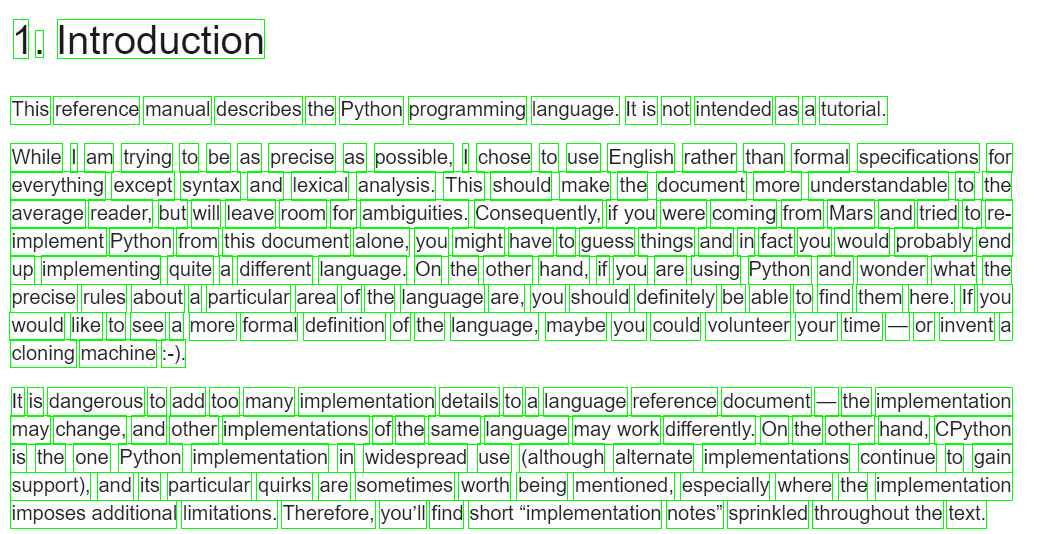

1 j. lintroduction
This reference manual describes the Python programming language. litis not intended as q tutorial.
While ,i am trying to be as precise as possible. ,i chose to use English rather than formal specifications for
everything except syntax and lexical analysis This should make th@ document more understandable to the
average reader; but will leave room for ambiguities. Consequentiy if' you were coming from Mars and tried to fie
implement Python from this loocument alone. you might have to guess things and in fact you would probably end
Up implementing quite da different language. On the other hand. if you are using Python and wonder what the
precise rules about q particular area of the language are, you should definitely be able to find them here. |f you
would like to see q more foirmal definition of the language, maybe you could volunteer your time  or invent a
cloning machine :.p,
|t is dangerous to add too many implementation details to da language refeience document  t

In [24]:
im = cv.imread(im_files[0], cv.IMREAD_GRAYSCALE)
word_bbs = seg_pipeline(im)
imdisplay(draw_segments(im, word_bbs))

for line_bb, line_word_bbs in word_bbs:
    print(' '.join(run_inference(imcrop(im, line_word_bbs, 1))))

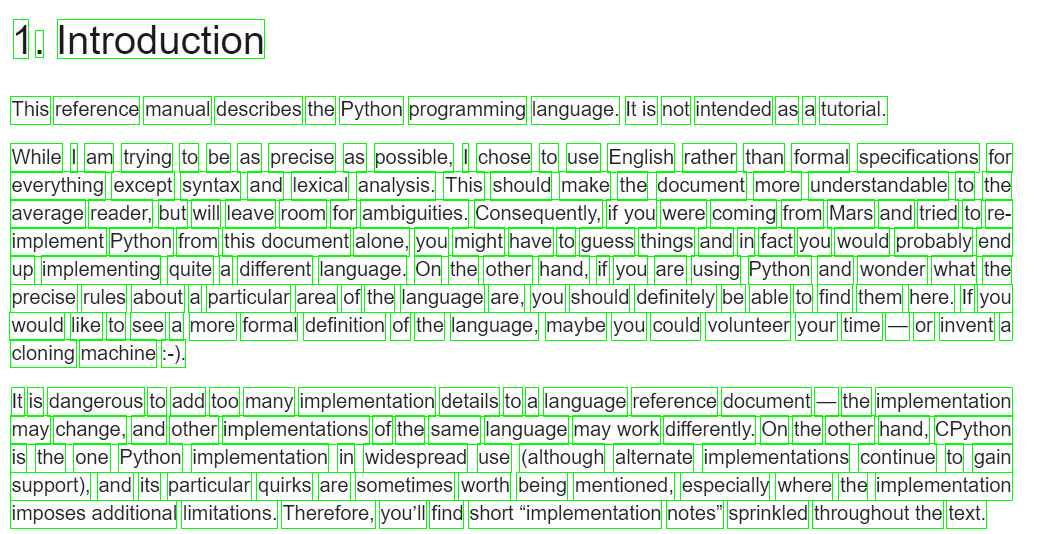

In [46]:
im = cv.imread(im_files[0], cv.IMREAD_GRAYSCALE)
word_bbs = seg_pipeline(im)
imdisplay(draw_segments(im, word_bbs))

In [9]:
!mkdir crops

In [10]:
for line_bb, line_word_bbs in word_bbs:
    crops = imcrop(im, line_word_bbs)
    for i, crop in enumerate(crops):
        cv.imwrite(f'crops/{i}.jpg', crop)
    break

In [21]:
import glob
from PIL import Image
crop_files = sorted(glob.glob('crops/*.jpg'))
print(crop_files)

['crops/0.jpg', 'crops/1.jpg', 'crops/10.jpg', 'crops/11.jpg', 'crops/12.jpg', 'crops/13.jpg', 'crops/14.jpg', 'crops/15.jpg', 'crops/16.jpg', 'crops/17.jpg', 'crops/18.jpg', 'crops/2.jpg', 'crops/3.jpg', 'crops/4.jpg', 'crops/5.jpg', 'crops/6.jpg', 'crops/7.jpg', 'crops/8.jpg', 'crops/9.jpg']


Python


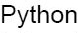

In [23]:
im = Image.open(crop_files[0])
print(predict(impreprocess(im)).strip())
im

In [32]:
cr = imcrop(im, line_word_bbs, 1)[0]

In [40]:
x = impreprocess(cr)
x.shape

torch.Size([1, 32, 512])

In [41]:
print(predict(x).strip())

Python
